In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
torch.manual_seed(1)

In [3]:
EPOCH =1
BATCH_SIZE= 64
TIME_STEP = 28
INPUT_SIZE = 28
LR = 0.01
DOWNLOAD_MNIST = True

In [4]:
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,
    transform=transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)

torch.Size([60000, 28, 28])
torch.Size([60000])


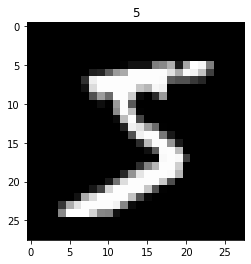

In [5]:
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [6]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [7]:
test_data = dsets.MNIST(
    root='./mnist/',
    train=False,
    transform=transforms.ToTensor()
)

test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000] / 255

test_y = test_data.test_labels.numpy().squeeze()[:2000]

In [8]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True        # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        
        self.out = nn.Linear(64, 10)
        
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])  # (batch, time_step, output_size)取最后一个time_step
        return out

In [9]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [10]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [11]:
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.2883 | test accuracy: 0.10
Epoch:  0 | train loss: 0.8712 | test accuracy: 0.58
Epoch:  0 | train loss: 0.9341 | test accuracy: 0.72
Epoch:  0 | train loss: 0.7127 | test accuracy: 0.80
Epoch:  0 | train loss: 0.2352 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2445 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3177 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3921 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1699 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2709 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1222 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2899 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0294 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1771 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1851 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0651 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0407 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0815 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1653 | test accuracy

In [12]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
